# Лабораторная работа №2
рынок: **Китай** <br>
период: **2018 год**

Седунов Илья, <br>
Альперович Вадим, <br>
Славутин Александр, <br>
17ПМИ.

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import warnings
import seaborn as sns
from seaborn import set_style
set_style('dark')
warnings.simplefilter('ignore')

In [2]:
df = pd.read_excel('data/china_stocks.xlsx').drop_duplicates(['Symbol'])
symbols = list(df['Symbol'])
print('China ticker symbols = ', len(symbols))

China ticker symbols =  2500


In [3]:
from IPython.display import clear_output
start = "2018-01-01"
end   = "2018-12-31"
stocks = {}

for symbol in tqdm_notebook(symbols):
    stocks[symbol] = yf.download(symbol, start=start, end=end, progress=False)
clear_output()
print('Акции собраны!')

Акции собраны!


In [6]:
print('Исторические данные для актива', symbols[120])
# stocks[symbols[120]].head()

Исторические данные для актива 300139.SZ


In [7]:
def get_descriptive_statistics(frame):
    E = frame["log_return"].mean()
    sigma = frame["log_return"].std()
    frame['E'] = E
    frame['Sigma'] = sigma
    return frame, E, sigma

def get_return(frame):
    frame['return'] = frame['Close'] / frame['Close'].shift(1)
    frame['log_return'] = np.log(frame['return'])
    return frame

In [8]:
stock_stat = pd.DataFrame(columns=['symbol',  'E', 'Sigma', 'mean_vol', 'mean_return', 'mean_log_return'])

for symbol in tqdm_notebook(symbols):
    stock = get_return(stocks[symbol])
    stock, E, Sigma = get_descriptive_statistics(stock)
    stock_stat.loc[symbol] = [symbol,
                               E,
                               Sigma, 
                               stock['Volume'].mean(), 
                               stock['return'].mean(), 
                               stock['log_return'].mean()]

In [9]:
stock_stat.dropna(inplace=True)
print('Осталось активов после обработки', len(stock_stat))
# stock_stat.head(3)

Осталось активов после обработки 2389


In [10]:
# SSE50 index
sse_components = pd.read_csv('data/SSE50.csv', names=['name', 'industry','symbol'])
sse50 = yf.download('^SSE50', start=start, end=end, progress=False)
sse50 = get_return(sse50)
_, E_sse50, Sigma_sse50 = get_descriptive_statistics(sse50)
# sse50.head(3)

In [11]:
def get_return_mean_cov(df): 
    r_matrix = {}
    for symbol in df['symbol']:
        r_matrix[symbol] = stocks[symbol]['log_return'] 
    r_df = pd.DataFrame(r_matrix)
    return r_df.values, r_df.mean().values, r_df.cov().values

def plot_mean_var_map(df,x='Sigma', y='E', title='Карта активов:σ от E', figsize=(12, 6)):
    ax = df.plot(x=x, y=y, s=np.log(df['mean_vol']**3), 
                          kind='scatter', 
                          figsize=figsize, 
                          edgecolor='black',
                          grid=True)
    plt.xlabel('Sigma', size=15)
    plt.ylabel('E', size=15)
    plt.title(title, size=16)

## 1. Efficient frontier. 
 1. Выбрать на рынке набор из 50 акций. 
 2. Построить эффективный фронт портфелей инвестиций без ограничений на короткие позиции и эффективный фронт с запретом  - коротких позиций. 
 3. Сравнить эффективные фронты и сделать выводы. 
 4. При построении эффективных фронтов вычислить портфели с минимальным риском и отметить их на соответствующем  эффективном фронте. 
 5. Рассмотреть портфель с равными долями вложения капитала и оценить, как далек этот портфель от эффективного фронта. 
 6. Тот же вопрос для индекса рынка.

### 1.1 Выбрать на рынке набор из 50 акций.

In [12]:
stock_stat['sharp'] = stock_stat['E'] / stock_stat['Sigma']
selected50 = stock_stat.sort_values(['sharp'], ascending=False).iloc[:1000].sample(50)
selected50.head()

,symbol,E,Sigma,mean_vol,mean_return,mean_log_return,sharp
300612.SZ,300612.SZ,-0.002115,0.045892,6.626999e+06,0.998935,-0.002115,-0.046092
002155.SZ,002155.SZ,-0.000874,0.021118,1.685397e+07,0.999347,-0.000874,-0.041407
601003.SS,601003.SS,-0.000803,0.033419,2.949917e+07,0.999753,-0.000803,-0.024041
600748.SS,600748.SS,-0.000729,0.019948,5.184552e+06,0.999469,-0.000729,-0.036535
000301.SZ,000301.SZ,0.000046,0.022142,1.040812e+07,1.000290,0.000046,0.002062


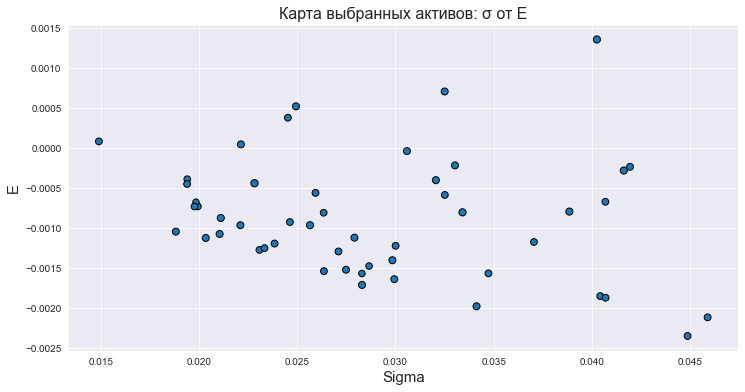

In [13]:
plot_mean_var_map(selected50, title='Карта выбранных активов: σ от E')

### 1.2 Построить эффективный фронт портфелей инвестиций 

In [30]:
from scipy.optimize import minimize

def risk_porfolio(X, cov_matrix):
    return np.sqrt(np.dot(np.dot(X, cov_matrix), X.T))

def optimize_portfolio(risk_porfolio,
                       returns, 
                       cov_matrix, 
                       bounds,
                       N, target_return=None):
    X = np.ones(N)
    X = X / X.sum()
    bounds = bounds * N

    constraints=[]
    constraints.append({'type': 'eq', 'fun': lambda X: np.sum(X) - 1.0})
    if target_return:
        constraints.append({'type': 'eq', 
                            'args': (returns,), 
                            'fun': lambda X, returns: portfolio_return - np.dot(X, returns)})

    return minimize(risk_porfolio, X,
                    args=(cov_matrix), method='SLSQP',
                    constraints=constraints,
                    bounds=bounds).x

 - без ограничений на короткие позиции 

$$ \begin{cases} \sum \sum x_i x_j \sigma_{ij} \rightarrow  min \\ \sum x_i = 1 \end{cases} $$

In [15]:
r_matrix, mean_vec, cov_matrix = get_return_mean_cov(selected50)

In [16]:
N = 50
psigmas = []
preturns = []
bounds = ((-1, 1),) 



X_min_risk = optimize_portfolio(risk_porfolio,
                           selected50['E'].values,
                           cov_matrix,
                           bounds, 
                           N)
min_risk = risk_porfolio(X_min_risk, cov_matrix)
min_risk_preturn = np.dot(X_min_risk, selected50['E'].values)
target_range = np.linspace(min_risk_preturn, 0.1, 20)
    
for portfolio_return in tqdm_notebook(target_range):
    X = optimize_portfolio(risk_porfolio,
                           selected50['E'].values,
                           cov_matrix,
                           bounds, 
                           N, 
                           target_return=portfolio_return)
    psigmas.append(risk_porfolio(X, cov_matrix))
    preturns.append(np.dot(X, selected50['E'].values))

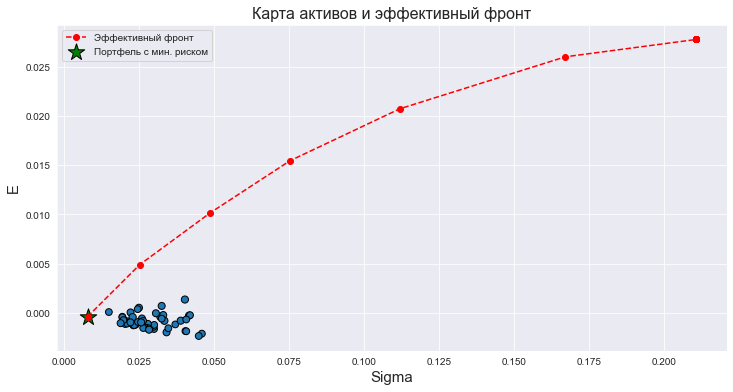

In [17]:
plot_mean_var_map(selected50, title='Карта активов и эффективный фронт')
plt.scatter(min_risk, min_risk_preturn, c='green',
            marker='*', s=300, label='Портфель с мин. риском', edgecolors='black',)
plt.plot(psigmas, preturns, 'ro--', label='Эффективный фронт')
plt.legend()
plt.show()

 -  с запретом  - коротких позиций.
$$ \begin{cases} \sum \sum x_i x_j \sigma_{ij} \rightarrow  min \\ \sum x_i = 1 \\ x_i > 0 \quad \forall i\end{cases} $$

In [18]:
N = 50
psigmas_no_short = []
preturns_no_short = []
bounds = ((0.0, 1.1),) 


X_min_risk_ns = optimize_portfolio(risk_porfolio,
                                   selected50['E'].values,
                                   cov_matrix,
                                   bounds, 
                                   N)
min_risk_ns = risk_porfolio(X_min_risk_ns, cov_matrix)
min_risk_preturn_ns = np.dot(X_min_risk_ns, selected50['E'].values)
target_range = np.linspace(min_risk_preturn_ns, 1, 20)


for portfolio_return in tqdm_notebook(target_range):
    X_no_short = optimize_portfolio(risk_porfolio,
                                   selected50['E'].values,
                                   cov_matrix,
                                   bounds, 
                                   N, 
                                   target_return=portfolio_return)
    psigmas_no_short.append(risk_porfolio(X_no_short, cov_matrix))
    preturns_no_short.append(np.dot(X_no_short, selected50['E'].values))

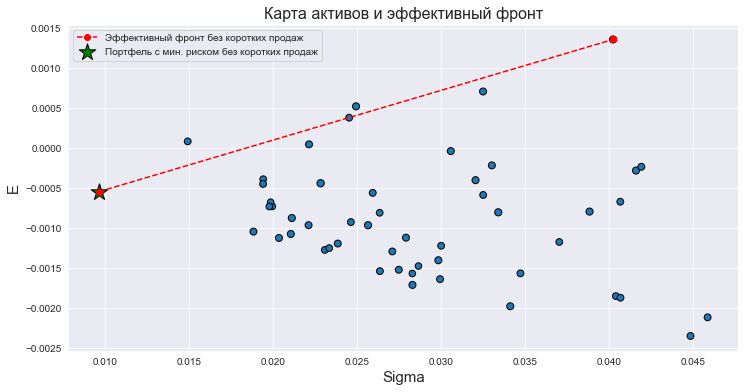

In [19]:
plot_mean_var_map(selected50, title='Карта активов и эффективный фронт')
plt.plot(psigmas_no_short, preturns_no_short, 'ro--', label='Эффективный фронт без коротких продаж')
plt.scatter(min_risk_ns, min_risk_preturn_ns, c='green',
            marker='*', s=300, edgecolors='black',
            label='Портфель с мин. риском без коротких продаж')
plt.legend()
plt.show()

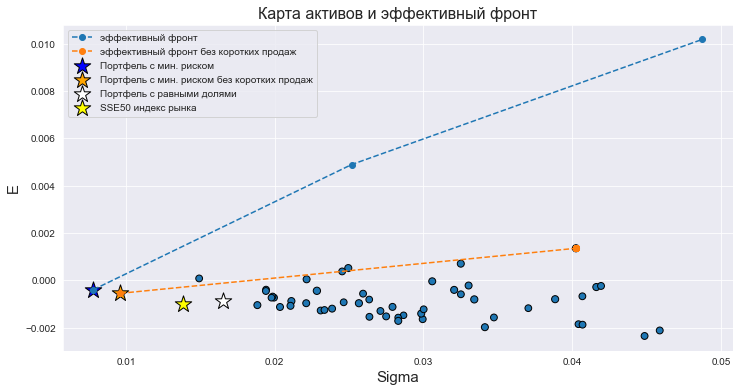

In [20]:
p = 3
plot_mean_var_map(selected50, title='Карта активов и эффективный фронт')
plt.plot(psigmas[:p], preturns[:p], 'o--', label='эффективный фронт')
plt.plot(psigmas_no_short, preturns_no_short, 'o--', label='эффективный фронт без коротких продаж')

plt.scatter(min_risk, min_risk_preturn, c='blue',
            marker='*', s=300, edgecolors='black',
            label='Портфель с мин. риском')

plt.scatter(min_risk_ns, min_risk_preturn_ns, c='orange',
            marker='*', s=300, edgecolors='black',
            label='Портфель с мин. риском без коротких продаж')

risk_pequals = risk_porfolio(np.ones(50) / 50 , cov_matrix ) 
return_pequals = np.dot((np.ones(50) / 50),  selected50['E'].values)
plt.scatter(risk_pequals, return_pequals, c='white',
            marker='*', s=300, label='Портфель с равными долями', edgecolors='black')

plt.scatter(Sigma_sse50, E_sse50, c='yellow',
            marker='*', s=300, label='SSE50 индекс рынка', edgecolors='black')

plt.legend()
plt.show()

**Комментарий:** ...

## 2. Portfolio selection problem. 
Требуется построить «хорошие» инвестиционные портфели из 10 активов вместо исходных 50 (или даже всех активов рынка). Предложите способ выбрать 10 активов (из отобранных ранее 50) для формирования портфеля. Сравните эффективные фронты всего набора (50 акций) и выбранного набора активов (10 акций) для двух случаев
 - короткие продажи разрешены,
 - короткие продажи запрещены.

In [953]:
# способ 1: генерим много раз подвыборку акций, выбираем с минимальной суммой матрицы ковариации
# samples = {}
# for i in range(1000):
#     sample = selected50.sample(10)
#     r_matrix, mean_vec, cov_matrix = get_return_mean_cov(sample)
#     cov_sum = cov_matrix.sum()
#     samples[cov_sum] = (r_matrix, mean_vec, cov_matrix, sample)
# r_matrix, mean_vec, cov_matrix, selected10 = samples[np.max(list(samples.keys()))]

In [21]:
# способ 2: выбираем 10 самых лучших акций по коэффициенту Шарпа
selected10 = stock_stat.sort_values(['sharp'], ascending=[False]).iloc[:10]
r_matrix, mean_vec, cov_matrix = get_return_mean_cov(selected10)

In [971]:
# способ 3: выбираем 10 самых лучших акций по риску
# selected10 = stock_stat.sort_values(['Sigma'], ascending=[True]).iloc[:10]
# r_matrix, mean_vec, cov_matrix = get_return_mean_cov(selected10)

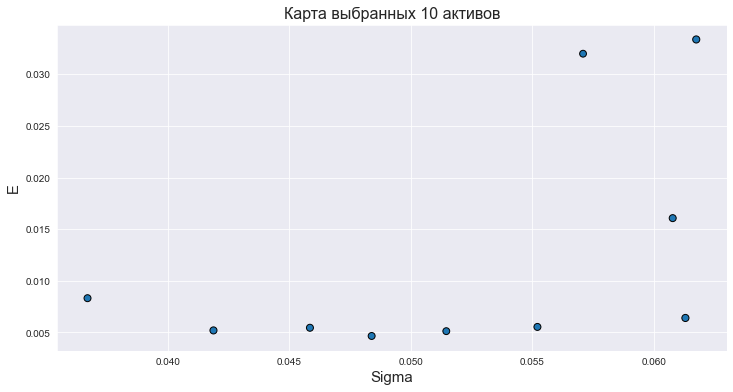

In [22]:
plot_mean_var_map(selected10, title='Карта выбранных 10 активов')

In [23]:
# эффективный фронт 

N = 10
psigmas10 = []
preturns10 = []
bounds = ((-1, 1),) 


X_min_risk10 = optimize_portfolio(risk_porfolio,
                                   selected10['E'].values,
                                   cov_matrix,
                                   bounds, 
                                   N)
min_risk10 = risk_porfolio(X_min_risk10, cov_matrix)
min_risk_preturn10 = np.dot(X_min_risk10, selected10['E'].values)
target_range = np.linspace(min_risk_preturn10, 0.1, 20)
    
for portfolio_return in tqdm_notebook(target_range):
    X = optimize_portfolio(risk_porfolio,
                           selected10['E'].values,
                           cov_matrix,
                           bounds, 
                           N, 
                           target_return=portfolio_return)
    psigmas10.append(risk_porfolio(X, cov_matrix))
    preturns10.append(np.dot(X, selected10['E'].values))

In [24]:
# эффективный фронт без коротких продаж

N = 10
psigmas10_no_short = []
preturns10_no_short = []
bounds = ((0, 1),) 



X_min_risk10 = optimize_portfolio(risk_porfolio,
                                   selected10['E'].values,
                                   cov_matrix,
                                   bounds, 
                                   N)
min_risk10 = risk_porfolio(X_min_risk10, cov_matrix)
min_risk_preturn10 = np.dot(X_min_risk10, selected10['E'].values)
target_range = np.linspace(min_risk_preturn10, 0.1, 20)
    
for portfolio_return in tqdm_notebook(target_range):
    X_no_short10 = optimize_portfolio(risk_porfolio,
                           selected10['E'].values,
                           cov_matrix,
                           bounds, 
                           N, 
                           target_return=portfolio_return)
    psigmas10_no_short.append(risk_porfolio(X_no_short10, cov_matrix))
    preturns10_no_short.append(np.dot(X_no_short10, selected10['E'].values))

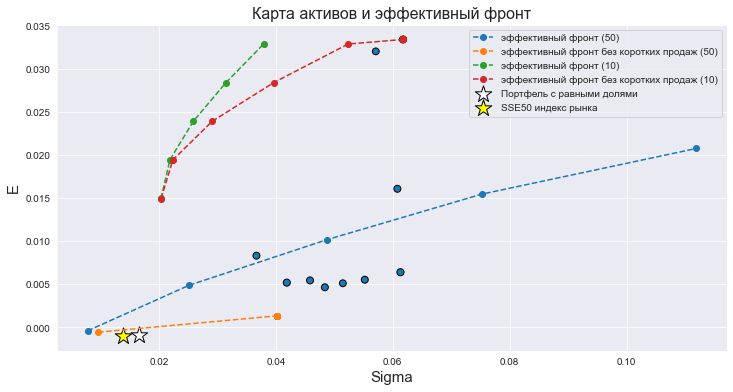

In [25]:
p = 5
plot_mean_var_map(selected10, title='Карта активов и эффективный фронт')


plt.plot(psigmas[:p], preturns[:p], 'o--', label='эффективный фронт (50)')
plt.plot(psigmas_no_short, preturns_no_short, 'o--', label='эффективный фронт без коротких продаж (50)')
plt.plot(psigmas10[:p], preturns10[:p], 'o--', label='эффективный фронт (10)')
plt.plot(psigmas10_no_short, preturns10_no_short, 'o--', label='эффективный фронт без коротких продаж (10)')


plt.scatter(risk_pequals, return_pequals, c='white',
            marker='*', s=300, label='Портфель с равными долями', edgecolors='black')

plt.scatter(Sigma_sse50, E_sse50, c='yellow',
            marker='*', s=300, label='SSE50 индекс рынка', edgecolors='black')

plt.legend()
plt.show()

**Комментарий:** ...

## 3. Risk aversion. 
Оцените свое отношение к риску и постройте свой личный оптимальный портфель инвестиций из выбранных 50 активов. Дайте характеристику портфеля по составу и долям активов. Оцените VaR доходностей портфеля. Рассмотрите два случая:

 - короткие продажи разрешены,
 - короткие продажи запрещены.

In [150]:
from scipy import stats

def objective_function(X, returns, risk_level, cov_matrix):
    # risk_level is alpha
    return - np.dot(returns, X) + risk_level * risk_porfolio(X, cov_matrix)
    
def optimize_risk_aversion_portfolio(objective_function, returns, cov_matrix, risk_level, bounds, N):
    X = np.ones(N)
    X = X / X.sum()
    bounds = bounds * N
    
    constraints=[]
    constraints.append({'type': 'eq', 'fun': lambda X: np.sum(X) - 1.0})
    
    return minimize(objective_function, X,
                    args=(returns, risk_level, cov_matrix), method='SLSQP',
                    constraints=constraints,
                    bounds=bounds).x
    
def risk_aversion_computing(params_):
    min_risk, min_risk_preturn, losses = [], [], {}
    N = len(params_['data'])
    E = params_['data']['E'].values
    _, _, cov_matrix = get_return_mean_cov(params_['data'])
    bounds = ((-1, 1),) if params_['short'] else ((0, 1),)
    for risk_level in params_['risk_levels']:
        X_min_risk = optimize_risk_aversion_portfolio(objective_function, E, cov_matrix, 
                                                      risk_level, bounds, N)
        min_risk.append(risk_porfolio(X_min_risk, cov_matrix))
        min_risk_preturn.append(np.dot(X_min_risk, E))
        log_return = np.log(X_min_risk * E)
        losses[risk_level] = - log_return
    return min_risk, min_risk_preturn, losses

params_50 = {}
min_risk, min_risk_preturn = [], []
params_50['short'] = True
params_50['data'] = selected50
params_50['risk_levels'] = [0.5, 0.7, 0.95]
losses = {} # вычислим потери как минус лог. доходности

min_risk, min_risk_preturn, losses = risk_aversion_computing(params_50)

 - без ограничений на короткие позиции 

$$ \begin{cases} f(x) = - E(x) + \alpha \sigma (x) \rightarrow min \\ \sum x_i = 1 \end{cases}$$

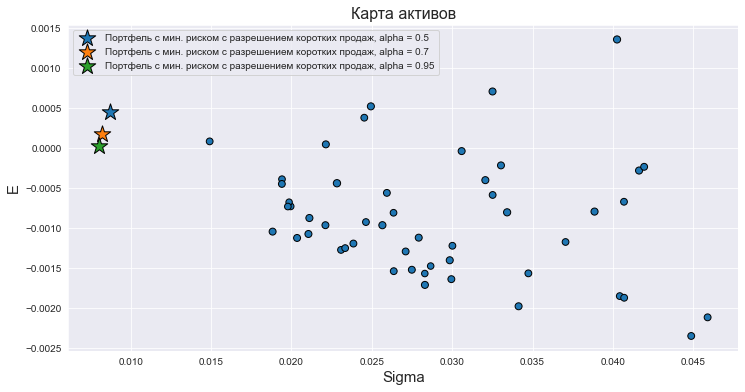

In [141]:
def plot_risk_aversion_method(params_, min_risk_, min_risk_preturn_, short=False):
    plot_mean_var_map(params_['data'], title='Карта активов')
    short_sales_word = 'разрешением' if short else 'запретом'

    for ind, risk_level in enumerate(params_['risk_levels']):
        plt.scatter(min_risk_[ind], min_risk_preturn_[ind],
                marker='*', s=300, label='Портфель с мин. риском с ' + short_sales_word + ' коротких продаж, alpha = ' + str(risk_level), 
                edgecolors='black',)
    plt.legend()
    plt.show()
plot_risk_aversion_method(params_50, min_risk, min_risk_preturn, True)

Рассчитаем **VaR** с помощью Variance-Covariance подхода

In [147]:
from scipy.stats import norm

def VaR_info(risk_levels_, losses_):
    confidence_lvl = [0.9, 0.95, 0.99]
    VaR = {}
    for risk_level in risk_levels_:
        print('VaR характеристика для портфеля с уровнем риска %s:' % risk_level)
        for clvl in confidence_lvl:
            loss = losses_[risk_level][np.isfinite(losses_[risk_level])]
            VaR[clvl] = np.quantile(loss, clvl)
            print(' - Потери не превысят %.4f с %.2f%s уверенностью.' % (VaR[clvl], clvl, '%'))
            
VaR_info(params_50['risk_levels'], losses)

VaR характеристика для портфеля с уровнем риска 0.5:
 - Потери не превысят 12.2730 с 0.90% уверенностью.
 - Потери не превысят 12.4747 с 0.95% уверенностью.
 - Потери не превысят 12.8567 с 0.99% уверенностью.
VaR характеристика для портфеля с уровнем риска 0.7:
 - Потери не превысят 12.7273 с 0.90% уверенностью.
 - Потери не превысят 13.3467 с 0.95% уверенностью.
 - Потери не превысят 14.4870 с 0.99% уверенностью.
VaR характеристика для портфеля с уровнем риска 0.95:
 - Потери не превысят 12.6040 с 0.90% уверенностью.
 - Потери не превысят 12.7219 с 0.95% уверенностью.
 - Потери не превысят 17.0290 с 0.99% уверенностью.


 - с ограничениями на короткие позиции 

$$ \begin{cases} f(x) = - E(x) + \alpha \sigma (x) \rightarrow min \\ \sum x_i = 1 \\ x_i > 0 \quad \forall i \end{cases}$$

In [145]:
params_50_no_short = params_50
params_50_no_short['short'] = False
losses_no_short = {} # вычислим потери как минус лог. доходности
min_risk_no_short, min_risk_preturn_no_short = [], []

min_risk_no_short, min_risk_preturn_no_short, losses_no_short = risk_aversion_computing(params_50_no_short)

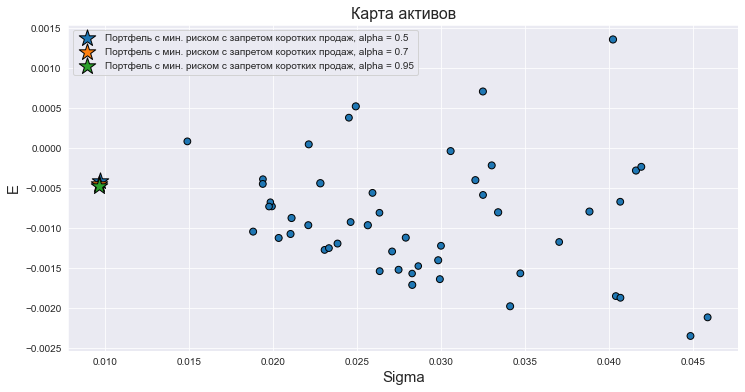

In [146]:
plot_risk_aversion_method(params_50_no_short, min_risk_no_short, min_risk_preturn_no_short, short=False)

In [148]:
VaR_info(params_50_no_short['risk_levels'], losses_no_short)

VaR характеристика для портфеля с уровнем риска 0.5:
 - Потери не превысят 33.1295 с 0.90% уверенностью.
 - Потери не превысят 39.5335 с 0.95% уверенностью.
 - Потери не превысят 44.6567 с 0.99% уверенностью.
VaR характеристика для портфеля с уровнем риска 0.7:
 - Потери не превысят 47.6155 с 0.90% уверенностью.
 - Потери не превысят 47.6550 с 0.95% уверенностью.
 - Потери не превысят 47.6867 с 0.99% уверенностью.
VaR характеристика для портфеля с уровнем риска 0.95:
 - Потери не превысят 47.6629 с 0.90% уверенностью.
 - Потери не превысят 48.0838 с 0.95% уверенностью.
 - Потери не превысят 48.4205 с 0.99% уверенностью.


## 4. Risk aversion and Portfolio selection.
Используя выбранное в п.3 отношение к риску постройте оптимальный портфель из 10 активов (вместо 50, см. п.2). Дайте характеристику этого портфеля по составу активов и долям инвестиций. Сравните с портфелем п.3. Оцените VaR доходностей портфеля. Рассмотрите два случая:

  - короткие продажи разрешены,
  - короткие продажи запрещены.

Проделаем ту же процедуру для отобранных 10 активов

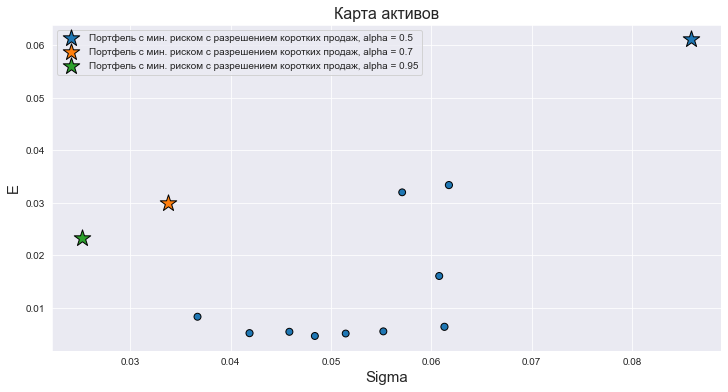

In [156]:
params_10 = params_50
params_10['short'] = True
params_10['data'] = selected10
losses, min_risk, min_risk_preturn = {}, [], []

min_risk, min_risk_preturn, losses = risk_aversion_computing(params_10)
plot_risk_aversion_method(params_10, min_risk, min_risk_preturn, short=True)

In [158]:
VaR_info(params_10['risk_levels'], losses)

VaR характеристика для портфеля с уровнем риска 0.5:
 - Потери не превысят 5.2591 с 0.90% уверенностью.
 - Потери не превысят 5.3138 с 0.95% уверенностью.
 - Потери не превысят 5.3576 с 0.99% уверенностью.
VaR характеристика для портфеля с уровнем риска 0.7:
 - Потери не превысят 7.8836 с 0.90% уверенностью.
 - Потери не превысят 8.4978 с 0.95% уверенностью.
 - Потери не превысят 8.9892 с 0.99% уверенностью.
VaR характеристика для портфеля с уровнем риска 0.95:
 - Потери не превысят 8.5659 с 0.90% уверенностью.
 - Потери не превысят 8.5858 с 0.95% уверенностью.
 - Потери не превысят 8.6017 с 0.99% уверенностью.


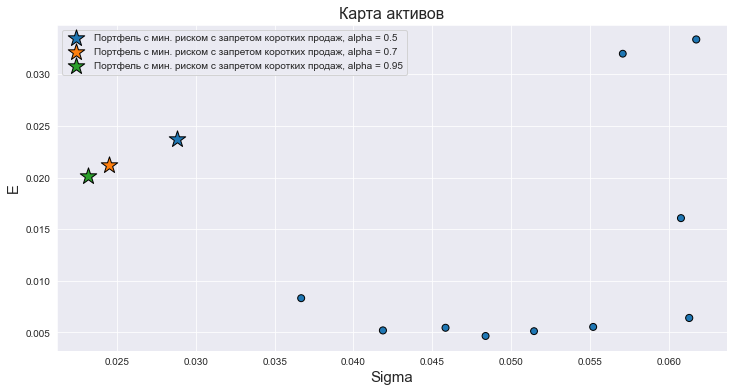

In [159]:
params_10_no_short = params_10
params_10_no_short['short'] = False
losses_ns, min_risk_ns, min_risk_preturn_ns = {}, [], []
min_risk_ns, min_risk_preturn_ns, losses_ns = risk_aversion_computing(params_10_no_short)
plot_risk_aversion_method(params_10_no_short, min_risk_ns, min_risk_preturn_ns, short=False)

In [160]:
VaR_info(params_10_no_short['risk_levels'], losses_ns)

VaR характеристика для портфеля с уровнем риска 0.5:
 - Потери не превысят 45.5116 с 0.90% уверенностью.
 - Потери не превысят 45.5664 с 0.95% уверенностью.
 - Потери не превысят 45.6103 с 0.99% уверенностью.
VaR характеристика для портфеля с уровнем риска 0.7:
 - Потери не превысят 29.6950 с 0.90% уверенностью.
 - Потери не превысят 37.3673 с 0.95% уверенностью.
 - Потери не превысят 43.5051 с 0.99% уверенностью.
VaR характеристика для портфеля с уровнем риска 0.95:
 - Потери не превысят 45.6755 с 0.90% уверенностью.
 - Потери не превысят 46.1026 с 0.95% уверенностью.
 - Потери не превысят 46.4442 с 0.99% уверенностью.


## 5. Markowitz-Tobin model. 
Рассмотрите набор активов, отобранных в п.2 (10 активов). Выберете безрисковый актив (можно виртуальный). Постройте рыночный (оптимальный) портфель. Сделайте анализ долей активов рыночного портфеля. Оцените VaR доходностей портфеля. Рассмотрите два случая:

 - короткие продажи разрешены,
 - короткие продажи запрещены.


## 6. Бонус. Индекс рынка.

Разберитесь, как составляется портфель индекса (определите веса, с которыми активы входят в индекс). Дайте характеристику индекса (гистограмма, распределение, выбросы). На основе метода главных компонент предложите свою модель индекса рынка. Сравните ваш индекс с индексом рынка.